In [1]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.color import rgb2gray
import cv2

Using TensorFlow backend.


In [2]:
#gpu_options = tf.GPUOptions(allow_growth=True)
#session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18173371585741311850
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1458703155
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10596308031324917141
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
# autoencoder=None
# from keras import backend as K
# K.clear_session()
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [4]:

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
# parameters that you should set before running this script
filter = ['plane', 'cat']#, 'chair', 'dog', 'bird']       # select class, this default should yield 1489 training and 1470 validation images
voc_root_folder = "./VOCdevkit/"  # please replace with the location on your laptop where you unpacked the tarball
image_size = 100    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)


# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]


def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([rgb2gray(resize(io.imread(img_f), (image_size, image_size, 3))) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y


x_train, y_train = build_classification_dataset(train_files)
print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))
x_val, y_val = build_classification_dataset(val_files)
print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

# from here, you can start building your model
# you will only need x_train and x_val for the autoencoder
# you should extend the above script for the segmentation task (you will need a slightly different function for building the label images)


467 training images from 2 classes
483 validation images from 2 classes


In [6]:
print(pd.Series(y_train[:,0]).value_counts() )
print(x_val[0].shape)
np.max(x_train[0])

0    266
1    201
dtype: int64
(100, 100)


0.9478518

In [7]:
# x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_val = x_val.astype('float32') / 255.
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
# x_train.shape

In [8]:
samples,total=x_train.shape


encoding_dim=1000
# this is our input layer
input_img = Input(shape=(total,))
    
# this is the bottleneck vector
encoded = Dense(encoding_dim, activation='sigmoid')(input_img)
    
# this is the decoded layer, with the same shape as the input
decoded = Dense(total, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [9]:
#tf.global_variables_initializer()
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_val, x_val))

Train on 467 samples, validate on 483 samples
Epoch 1/100
467/467 [==============================] - 8s 17ms/step - loss: 0.1052 - val_loss: 0.0544
Epoch 2/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0543 - val_loss: 0.0533
Epoch 3/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0534 - val_loss: 0.0524
Epoch 4/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0526 - val_loss: 0.0519
Epoch 5/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0520 - val_loss: 0.0512
Epoch 6/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0514 - val_loss: 0.0506
Epoch 7/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0508 - val_loss: 0.0500
Epoch 8/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0501 - val_loss: 0.0495
Epoch 9/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0495 - val_loss: 0.0486
Epoch 10/100
467/467 [==============

467/467 [==============================] - 6s 13ms/step - loss: 0.0264 - val_loss: 0.0284
Epoch 81/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0263 - val_loss: 0.0283
Epoch 82/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0262 - val_loss: 0.0282
Epoch 83/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0261 - val_loss: 0.0281
Epoch 84/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0259 - val_loss: 0.0280
Epoch 85/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0258 - val_loss: 0.0278
Epoch 86/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0257 - val_loss: 0.0277
Epoch 87/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0256 - val_loss: 0.0277
Epoch 88/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0255 - val_loss: 0.0275
Epoch 89/100
467/467 [==============================] - 6s 13ms/step - loss: 0.0254 - 

In [10]:
encoded_imgs = encoder.predict(x_val)
decoded_imgs = decoder.predict(encoded_imgs)

In [11]:
np.max(x_val[0])

0.9586373

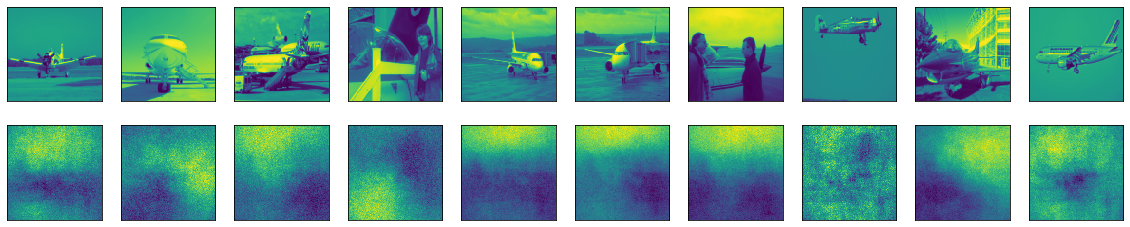

In [14]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(image_size, image_size)) 
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size) )
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()